Compared to MNIST dataset, CIFAR10 images have 3 channels rather than 1. Also, we use a momentum optimizer with an initial learning rate of 0.01 (decaying by a factor of 0.95 every 390 epochs) and momentum of 0.9, just like in the [ICLR 2017 paper](https://arxiv.org/pdf/1611.03530.pdf). Also, batches sizes are 128 rather than 256.

The CIFAR10 images are also preprocessed via whitening, as described in the above paper.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2

import pickle
import time
import tensorflow as tf
import numpy as np

from analysis import *

%matplotlib inline

In [3]:
from get_cifar10 import get_cifar10_dataset
n_samps = 50000

# each value: Xtr, Ytr, Xtt, Ytt
data = {
    'true': get_cifar10_dataset(0, n_samps=n_samps),
    'rand': get_cifar10_dataset(100, n_samps=n_samps)
}
C2 = np.mean([np.sqrt(np.sum(np.square(i))) for i in data['true'][0]])
gamma = 0.04*C2
eps_wrm = 1./(2*gamma)

batch_size = 128
num_channels = 3

### Inception

In [4]:
from spectral_adversarial_regularization.models import inception as model

# Estimate eps for the other samples using the perturbation achieved for each test sample
save_dir = os.path.join('save_weights', 'cifar10', 'inception', 'inception_wrm_true')
arch = model.inception

Xtr = data['true'][2]
Xtr_adv_wrm = ad.build_graph_and_gen_adv_examples(Xtr, arch, save_dir, beta=1, num_channels=3,
                                                  load_epoch=200, method=ad.wrm, eps=eps_wrm)
    
eps = np.sqrt(np.mean([np.sum(np.square(i)) for i in Xtr_adv_wrm-Xtr])) 

# Note: the above eps/C2 is 0.0106065673, but we'll use 0.01
eps = 0.01

INFO:tensorflow:Restoring parameters from save_weights/cifar10/inception/inception_wrm_true/checkpoints/epoch36
0.516582042815


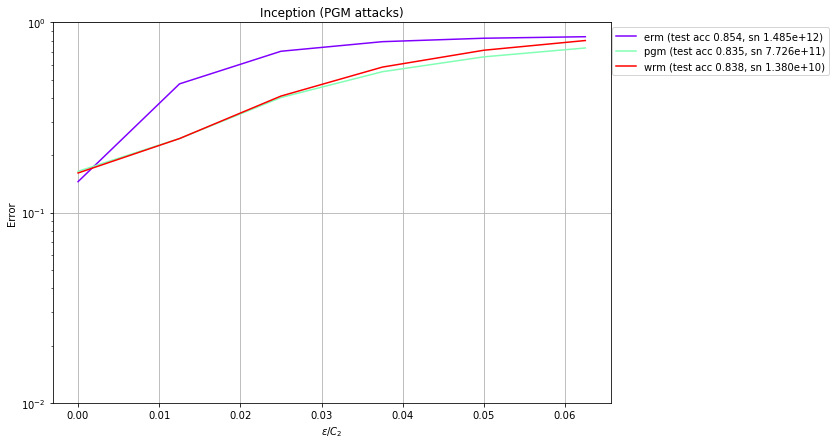

In [9]:
# Evaluate robustness of networks

from spectral_adversarial_regularization.models import inception as model

labeltype = 'true'
arch = model.inception
archname = 'inception'
methods = ['erm', 'pgm', 'wrm']
eps_list = np.linspace(0, 0.0625, 6)*C2

curves_file = 'save_weights/cifar10/inception/adv_attack_curves.pickle'

if os.path.isfile(curves_file):
    adv_results = pickle.load(file(curves_file, 'rb'))
else:
    adv_results = get_curves_for_arch(data, labeltype, arch, methods, eps_list, archname)
    pickle.dump(adv_results, file(curves_file, 'wb'))

plot_acc_curves(adv_results, eps_list/C2, title='Inception (PGM attacks)')

### Alexnet

In [4]:
from spectral_adversarial_regularization.models import alexnet as model

# Estimate eps for the other samples using the perturbation achieved for each test sample
save_dir = os.path.join('save_weights', 'cifar10', 'alexnet', 'alexnet_wrm_true')
arch = model.alexnet

Xtr = data['true'][2]
Xtr_adv_wrm = ad.build_graph_and_gen_adv_examples(Xtr, arch, save_dir, beta=1, num_channels=3,
                                                  load_epoch=200, method=ad.wrm, eps=eps_wrm)
    
eps = np.sqrt(np.mean([np.sum(np.square(i)) for i in Xtr_adv_wrm-Xtr])) 
print(eps)

# Note: the above eps/C2 is 0.0103616317, but we'll use 0.01
eps = 0.01

INFO:tensorflow:Restoring parameters from save_weights/cifar10/alexnet/alexnet_wrm_true/checkpoints/epoch25
0.504652706597


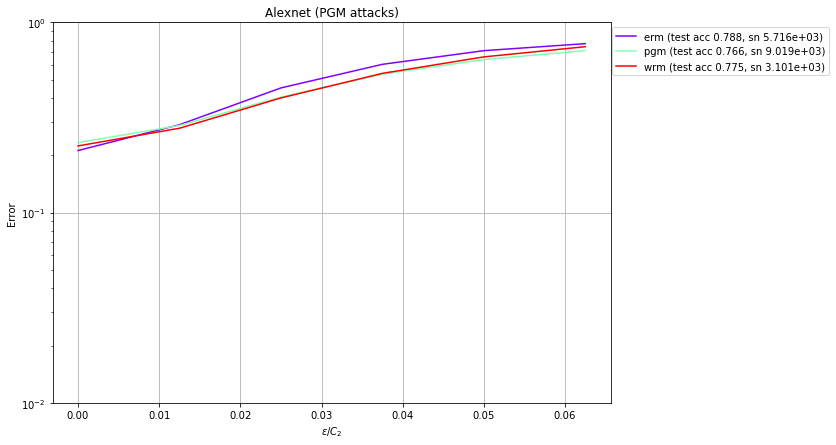

In [11]:
# Evaluate robustness of networks

from spectral_adversarial_regularization.models import alexnet as model

labeltype = 'true'
arch = model.alexnet
archname = 'alexnet'
methods = ['erm', 'pgm', 'wrm']
eps_list = np.linspace(0, 0.0625, 6)*C2

curves_file = 'save_weights/cifar10/alexnet/adv_attack_curves.pickle'

if os.path.isfile(curves_file):
    adv_results = pickle.load(file(curves_file, 'rb'))
else:
    adv_results = get_curves_for_arch(data, labeltype, arch, methods, eps_list, archname)
    pickle.dump(adv_results, file(curves_file, 'wb'))

plot_acc_curves(adv_results, eps_list/C2, title='Alexnet (PGM attacks)')